# Conditional Probability Table

|              	| Museum 	| Concert 	| Sports Event 	| Restaurant 	| Hike 	|
|--------------	|--------	|---------	|--------------	|------------	|------	|
| Museum       	| 0.07   	| 0.20    	| 0.33         	| 0.20       	| 0.20 	|
| Concert      	| 0.33   	| 0.05    	| 0.19         	| 0.29       	| 0.14 	|
| Sports Event 	| 0.38   	| 0.10    	| 0.10         	| 0.24       	| 0.19 	|
| Restaurant   	| 0.28   	| 0.22    	| 0.28         	| 0.17       	| 0.06 	|
| Hike         	| 0.15   	| 0.31    	| 0.08         	| 0.38       	| 0.08 	|

# Import Data, Generate Transition Matrix

In [2]:
import pandas as pd

data = {
    'Museum': [1, 3, 5, 3, 3],
    'Concert': [7, 1, 4, 6, 3],
    'Sports Event': [8, 2, 2, 5, 4],
    'Restaurant': [5, 4, 5, 3, 1],
    'Hike': [2, 4, 1, 5, 1]
}

df = pd.DataFrame(data, index=['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike'])

totals = df.sum(axis=1)

transition_matrix = df.divide(totals, axis=0)

print(transition_matrix.round(2))


              Museum  Concert  Sports Event  Restaurant  Hike
Museum          0.04     0.30          0.35        0.22  0.09
Concert         0.21     0.07          0.14        0.29  0.29
Sports Event    0.29     0.24          0.12        0.29  0.06
Restaurant      0.14     0.27          0.23        0.14  0.23
Hike            0.25     0.25          0.33        0.08  0.08


# Generate graph and display

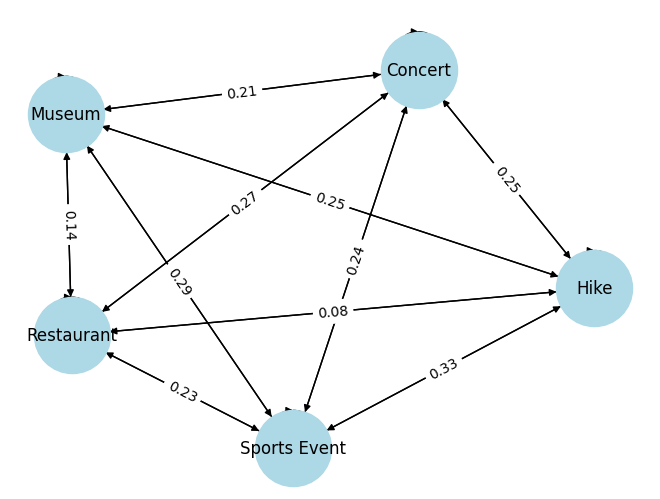

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
for location in transition_matrix.index:
    G.add_node(location)

# Add edges with weights
for i, row in transition_matrix.iterrows():
    for j, prob in row.items():
        if prob > 0:  # Only add edges for non-zero probabilities
            G.add_edge(i, j, weight=prob, label=f"{prob:.2f}")

pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=12)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

### Get transition matrix values

In [25]:
P = transition_matrix.values

In [27]:
activities = ['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike']

In [29]:
stylized_matrix = pd.DataFrame(P, columns=activities, index=activities)
stylized_matrix

,Museum,Concert,Sports Event,Restaurant,Hike
Museum,0.043478,0.304348,0.347826,0.217391,0.086957
Concert,0.214286,0.071429,0.142857,0.285714,0.285714
Sports Event,0.294118,0.235294,0.117647,0.294118,0.058824
Restaurant,0.136364,0.272727,0.227273,0.136364,0.227273
Hike,0.250000,0.250000,0.333333,0.083333,0.083333


# Solve for the Steady-State Probabilities

Solve for the problem πA=π, where A is P, our transition matrix. Essentially, we are looking for the eigenvector of the transition matrix P that corresponds to an eigenvalue of 1.

In the code below, we do not directly solve the eigenvalue problem but instead use the property of Markov chains that allows us to repeatedly apply the transition matrix to an (or any) initial disitrubtion, which eventually converges to the steady-state distribution.

In [9]:
import numpy as np
import pandas as pd

# Start with an initial distribution pi
pi = np.full((P.shape[0],), 1 / P.shape[0])

### Display distribution vector

In [10]:
pi

array([0.2, 0.2, 0.2, 0.2, 0.2])

### Solve

In [11]:

threshold = 1e-6 # set a very low threshold
iterations = 0
delta = 1  # change in pi

# While our change in pi is less than our threshold, 
# repeatedly apply P to the current dist. of pi to get a new dist pi_new
# Then, store the distribution change in pi as delta
while delta > threshold:
    pi_new = pi @ P  # Matrix multiplication of pi by P
    delta = np.linalg.norm(pi_new - pi)  # Calculate the change in the probabilities
    pi = pi_new
    iterations += 1

# pi now holds the steady-state distribution, and iterations tells us how many steps it took to get there


### How many iterations did it take for us to get to the steady-state probabilities?

In [7]:
iterations

10

### Print the steady-state distribution defined by P

In [8]:
pi

array([0.1888363 , 0.2221303 , 0.22315593, 0.21187705, 0.15400042])

### Confirm that pi * P = pi

In [18]:
pi_P = np.dot(pi, P)
print(f"pi*P = {pi_P}")
print(f"pi = {pi}")

pi*P = [0.18883615 0.2221304  0.22315608 0.21187696 0.15400041]
pi = [0.1888363  0.2221303  0.22315593 0.21187705 0.15400042]


### Confirm that the sum of elements of pi is = 1

The sum of probabilities for all possible outcomes should be equal to 1.

In [19]:
np.sum(pi)

0.9999999999999999

# Illustrate the Steady-State Distribution

The steady-state probabilities for each state - each activity - tell us the popularity of each activitity and help us understand the likelihood that a large proportion of tourists would choose the activity as their next visit. Boiled down, its a 'snapshot' predictive model.

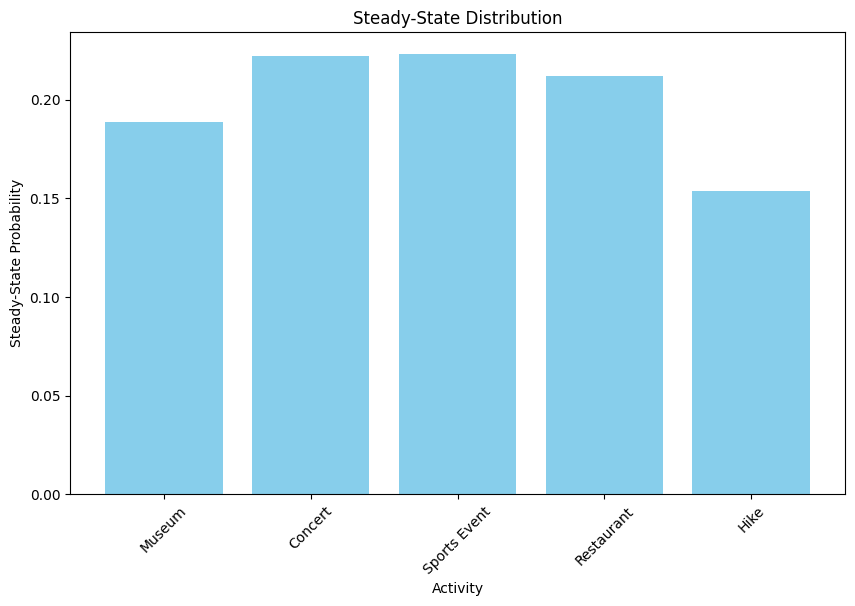

In [24]:
plt.figure(figsize=(10, 6))
states_labels = ['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike']
plt.bar(states_labels, pi, color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Steady-State Probability')
plt.title('Steady-State Distribution')
plt.xticks(rotation=45)
plt.show()


# In tour of only three locations, how likely is a tourist to attend a concert, go on a hike, then eat at a restaurant?

The likelihood of a tourist attending a concert, then going on a hike, and then finally eating at a restaurant is the product of transition probabilities for each step of the sequence.

This is based on the Markov property where the probability of transitioning to a future state (Activity) depends **only on the current state** and not on the sequence of events that precede it.

### Remember back to our transition matrix:

In [30]:
stylized_matrix

,Museum,Concert,Sports Event,Restaurant,Hike
Museum,0.043478,0.304348,0.347826,0.217391,0.086957
Concert,0.214286,0.071429,0.142857,0.285714,0.285714
Sports Event,0.294118,0.235294,0.117647,0.294118,0.058824
Restaurant,0.136364,0.272727,0.227273,0.136364,0.227273
Hike,0.250000,0.250000,0.333333,0.083333,0.083333


So, we find the probability by calculating:

P(Concert -> Hike) * P(Hike -> Restaurant)

Given the values, we then have:

0.285 * 0.083

Which equals:

0.023655 or 2.3655%

# What is the likelihood of visiting any of the locations as the fifth step?

Using the following approach:

Since there are five possible locations to start the tour and the starting state distribution is uniform, the starting *probability vector*, *spv = [0.2, 0.2, 0.2, 0.2, 0.2].*

We need to compute the fifth entry of the starting probability vector by multiplying the *spv* by the fifth power of the transition matrix.

So, we first define *spv* and then raise P to the fifth power. Finally, we multiply *spv* by *P^5*.

In [37]:
spv = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

P_5 = np.linalg.matrix_power(P, 5)

fifth_step_probabilities = np.dot(spv, P_5)

fifths = pd.Series(fifth_step_probabilities, index=activities)

fifths_percents = fifths.apply(lambda x: f"{x:.2%}")

### Probability for visiting each Activity as the fifth step:

In [ ]:
fifths_percents